# Predicting IMDB Reviews Using Natural Language Processing

### Dataset
This project uses NLP (natural language processing) to predict the sentiment of imdb movies. The dataset consists of 50,000 labeled movie reviews from Kaggle: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews. 



## Setup

In [2]:
#importing libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

from bs4 import BeautifulSoup

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, get_scorer_names, mean_squared_error, r2_score, roc_auc_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis


In [3]:
imdb = pd.read_csv("IMDBDataset.csv")
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
imdb.shape

(50000, 2)

In [15]:
imdb.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


### Checking for duplicated entries
It looks like there are 50,000 reviews in the dataset, but only 49,582 unique reviews. 
I'll use the .duplicated() method to see if this is true. 

In [5]:
has_duplicates = imdb.duplicated().any()
print(has_duplicates)

True


In [8]:
# get the count of each review
review_counts = imdb['review'].value_counts()

# filter for only the duplicated reviews
duplicates = review_counts[review_counts > 1]

# convert duplicates series to a dictionary
duplicate_counts = duplicates.to_dict()

In [22]:
#Seeing which reviews are duplicated, and the amount of times they are 
amount = 0
for review, count in duplicate_counts.items():
    if amount < 3: 
        print(f"Review:\n '{review}'\n\nAppears {count} times:")
        print(imdb.loc[imdb['review'] == review])
        print()
        amount += 1
    else:
        break

Review:
 'Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed.'

Appears 5 times:
                                                  review sentiment
5213   Loved today's show!!! It was a variety and not...  positive
12531  Loved today's show!!! It was a variet

**Since there are several reviews with duplicate entries, we will drop all but one of duplicate reviews to reduce the computational burden during prediction.**

In [6]:
imdb.drop_duplicates(subset=['review'], keep='first', inplace=True)

In [7]:
print(f"Entries dropped: {50000-imdb.shape[0]}")

Entries dropped: 418


In [149]:
# Making sure all duplicates has been dropped
has_duplicates = imdb.duplicated().any()
print(has_duplicates)

False


### Checking for Missing Values

In [54]:
missing_values = imdb.isnull().sum()
print(missing_values.head())

review       0
sentiment    0
dtype: int64


#### What is the ratio of positive and negative sentiment reviews?

In [96]:
imdb['sentiment'].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

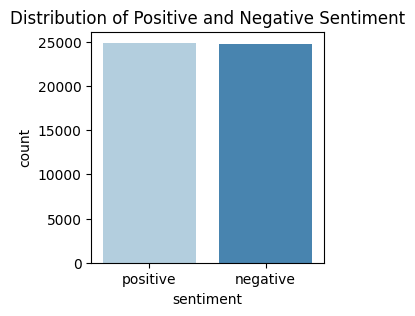

In [85]:
plt.figure(figsize = (3, 3))
sns.countplot(x=imdb['sentiment'], palette = 'Blues')
plt.yticks(range(0, 30000, 5000));
plt.title("Distribution of Positive and Negative Sentiment");

After dropping duplicate variables and checking for missing values, the dataset has 49,582 unique reviews and 2 features. There are 24,690 negative sentiment reviews and 24,884 positive sentiment reviews. 

# Visualizing the Text

## Word Clouds

In [ ]:
# seperating positive and negative reviews 
positive_reviews = imdb[imdb['sentiment'] == 'positive']['review']
negative_reviews = imdb[imdb['sentiment'] == 'negative']['review']

# join the positive and negative reviews into strings
positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

# generate word clouds for positive and negative reviews
pos_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(positive_text)
neg_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(negative_text)

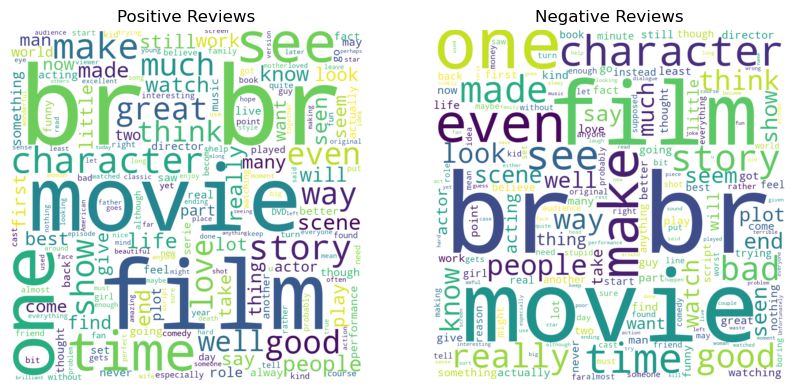

In [62]:
# Plot the word clouds
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(pos_wordcloud, interpolation='bilinear')
axes[0].set_title('Positive Reviews')
axes[0].axis('off')

axes[1].imshow(neg_wordcloud, interpolation='bilinear')
axes[1].set_title('Negative Reviews')
axes[1].axis('off')

plt.show()

### Cleaning Reviews
Before creating the prediction models, we have to process the text so that it can be prepared for the prediction task.

Let's take a look at an example review to clean: 

In [89]:
print(imdb.review[0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

**In order for this text to be ready for analysis, we have to remove the html tags, stop words ('a', 'and', 'the', etc.), and other characters that do not carry significant meaning. This is to lower computational burden when we conduct our analysis later on. I chose to keep the punctuation because it might be predictive for the sentiment of different reviews.**

### To put it all together:

**Steps:** 
1. Tokenize and lowercase the text
2. Remove unnecessary characters and Stop Words
3. Perform Stemming- get the root word of each word. For example, "duplicated," "duplicating," and "duplicates" all come from the same root word "duplicate." Stemming is performed to normalize the words since they express similar sentiments. 

In [57]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove html tags
    text = BeautifulSoup(text).get_text()

    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if not token in stop_words]

    # Stem the tokens
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

    # Join the tokens back into a string
    preprocessed_text = ' '.join(stemmed_tokens)

    return preprocessed_text

# Preprocess the text
preprocessed_text = preprocess_text(imdb.review[0])
print(f"How text looks like after preprocessing:\n\n {preprocessed_text}")

How text looks like after preprocessing:

 one review mention watch 1 oz episod 'll hook . right , exactli happen me.th first thing struck oz brutal unflinch scene violenc , set right word go . trust , show faint heart timid . show pull punch regard drug , sex violenc . hardcor , classic use word.it call oz nicknam given oswald maximum secur state penitentari . focus mainli emerald citi , experiment section prison cell glass front face inward , privaci high agenda . em citi home mani .. aryan , muslim , gangsta , latino , christian , italian , irish .... scuffl , death stare , dodgi deal shadi agreement never far away.i would say main appeal show due fact goe show would n't dare . forget pretti pictur paint mainstream audienc , forget charm , forget romanc ... oz n't mess around . first episod ever saw struck nasti surreal , could n't say readi , watch , develop tast oz , got accustom high level graphic violenc . violenc , injustic ( crook guard 'll sold nickel , inmat 'll kill order g

In [9]:
# applying to the review column 
imdb['review_prep'] = imdb['review'].apply(preprocess_text)

# Prediction Task

In [10]:
# turn sentiment into binary variable
imdb['binary_sent'] = imdb['sentiment'].map({'positive': 1, 'negative': 0})

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    imdb['review_prep'], imdb['binary_sent'], test_size=0.2, random_state=123)

## Bag of Words Approach
Bag of Words represents each text as a vector with the counts of each word. However, this means that words that appear more frequently have higher value counts, which can be less effective for our dataset. From the word cloud, we can see that positive and negative reviews share many similar words such as: "movie," "film," and "good". Thus, those words are less predictive but the Bag of Words approach does not account for that. 

In [14]:
# Vectorize text using Bag-of-Words model
vectorizer = CountVectorizer(analyzer = 'word')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# train the classifier
clf = MultinomialNB()
clf.fit(X_train_vec, y_train)

# make the prediction using the trained model
y_pred = clf.predict(X_test_vec)

# confusion matrix
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      4925
           1       0.86      0.83      0.85      4992

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



array([[4269,  656],
       [ 831, 4161]])

The Naive Bayese classifier was able to achieve an 85 percent accuracy on the predictions but seems to predict poorly for positive sentiment in particular. It predicted that 831 reviews were negative sentiemnt when they were really positive. I will continue on using TFIDF and other models to see if the accuracy of the model can be improved. 

## TFIDF
I will be using TFIDF (term frequency-inverse document frequency) to transform the text into vectors because it takes into account both the count of the word and its frequency across documents, so it will weigh words that appear more commonly, such as "movie" and "film," less. This will allow more informative and unique words to have more predictive power. 

#### Creating the Tfidf Vectorizer: 

`sublinear_tf`: set to `True` to minimize the impact of common words

`analyzer`: set to 'word' to set the frequency of each word as the unit of analysis 

In [11]:
tfidf = TfidfVectorizer(sublinear_tf = True, analyzer='word')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### Naive Bayes
Naive Bayes gets its name because it makes the naive assumption that each word in the text is independent of other words, but because of that, it is a faster model that can be good for text data. 

In [12]:
#Naive Bayes
nbayes = MultinomialNB().fit(X_train_tfidf,y_train)
y_pred_naiveb = nbayes.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_naiveb))
confusion_matrix(y_test, y_pred_naiveb)

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      4925
           1       0.86      0.85      0.86      4992

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



array([[4254,  671],
       [ 743, 4249]])

In comparison to the Naive Bayes model using Bag of Words, we can already see that the untuned tfidf model is one percent more accurant in comparison. It seems to improve in predicting positive sentiment but performs a little more poorly for negative sentiment reviews.

### Random Forest

In [29]:
# Random Forest
rf = RandomForestClassifier(n_estimators=50, random_state=123)
rf.fit(X_train_tfidf, y_train)

#making the prediction 
rf_y_pred = rf.predict(X_test_tfidf)

# confusion matrix
print(classification_report(y_test, rf_y_pred))
confusion_matrix(y_test, rf_y_pred)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      4925
           1       0.84      0.82      0.83      4992

    accuracy                           0.83      9917
   macro avg       0.84      0.83      0.83      9917
weighted avg       0.84      0.83      0.83      9917



array([[4170,  755],
       [ 883, 4109]])

The Random Forest model performed very poorly in comparison to the two Naive Bayes model. However, I did decrease the number of estimators to expediate the computation time when optimally, `n_estimators` should be slightly higher for more effective results. If I had more time, I would try to tune this model and find the optimal `n_estimators`. 

### Support Vector Machine
SVM is good for this dataset because it can create a hyperplane that seperates negative and positive sentiment. 

In [17]:
#SVM
## Linear SVM (Support Vector Classifier)
svc = SVC(kernel = 'linear').fit(X_train_tfidf, y_train)
y_pred_svc = svc.predict(X_test_tfidf)

print(confusion_matrix(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

#this took like 25 minutes

[[4365  560]
 [ 508 4484]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4925
           1       0.89      0.90      0.89      4992

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



The SVM model performed more accuractly than the past models at 89 percent accuracy and higher precision and recall for both positive and negative sentiment. This model can be improved if it is tuned to find the best `C` parameter. 

### Logistic Regression 

In [15]:
Cs = np.logspace(-2, 2, 100)

#find best parameters
param_grid = {
    'C':Cs
}
logreg = LogisticRegression(penalty='l2', solver='saga', max_iter=1000000)
search = GridSearchCV(logreg, param_grid, cv=5)
search.fit(X_train_tfidf, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
#took about 15-20 min to run!

Best parameter (CV score=0.894):
{'C': 4.641588833612782}


In [16]:
#Fit model with testing set
log_model = search.best_estimator_ 
log_y_pred = log_model.predict(X_test_tfidf)

#Confusion matrix and classification report 
print(confusion_matrix(y_test, log_y_pred))
print(classification_report(y_test, log_y_pred))

[[4382  543]
 [ 506 4486]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4925
           1       0.89      0.90      0.90      4992

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



After tuning the Logistic Regression model, I found that the best C is 4.642 and after using that parameter for the prediction, the model achieved the same accuracy score as the SVM model of 89 percent accuracy. However, the logisitic regression model peforms slightly better in terms of precision and recall, so it is the best model so far for this prediction task. 

# Conclusion

After tuning the Logistic Regression Model, it achieved an 89 percent accuracy and f1-score, which is similar to the Support Vector Machine model. However, the Logistic Regression Model is slightly better with higher precision and recall scores (by about one percent). This model is limited because I didn't have the computational power to tune the SVM model. If I were to continue working on this project, I would decrease the training dataset size to alleviate some computational burden in finding a better tuning parameter, or by decreasing the number of features. It might lead to less accurate test results but based on how the untuned SVM model performs at the same level as the Logistic Regression, a tuned model on a small training set will probably still perform well. 

### Exploring Some Reviews the Classifier Performed Poorly On: 

In [68]:
count = 0
for i in range(len(y_test)):
    if y_test.iloc[i] != log_y_pred[i] and count < 10:
        print(f'Review {i}: {X_test.iloc[i]}')
        print(f'Actual sentiment: {["Negative" if y_test.iloc[i] == 0 else "Positive"][0]}')
        print(f'Predicted sentiment: {["Negative" if log_y_pred[i] == 0 else "Positive"][0]}')
        print('---')
        count+=1

Review 13: like best flick chanc see joan woodburi , awe-struck one sever beauti charl boyer classic `` algier '' , lead role . well rita , orphan rise make good ladi crime boss . ascent top remind joan crawford 's charact , e.g . mildr pierc , realiz ambit fierc determin willpow . 're look film noir classic , better look elsewher . sever point , 's difficult know stori go . first got impress go encompass rita 's plot reveng father son trick take rap drunk drive death perpetr playboy son . payback time end minor point , springboard somewhat confus second part film , rita becom increasingli involv citi corrupt . anyway , 's 72 minut , second view clear hazi . copi platinum box set call `` mobster movi '' . pictur qualiti good , soundtrack suck , constantli skip fragment dialog . eight film $ 5.50 box , make movi fair 69 cent . look ann archer 's father , john archer , rita 's childhood friend bob . alan ladd n't get much screen time . 's definit joan woodburi 's pictur .
Actual sentimen